In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_24688\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - jesen

In [4]:
autumn_mask = accidents['NastanekDatumCas'].dt.month.isin([9, 10, 11])

autumn_accidents = accidents[autumn_mask]
# print(f"NastanekDatumCas column dtype: {autumn_accidents['NastanekDatumCas'].dtype}")

hours = autumn_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsAutumn",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

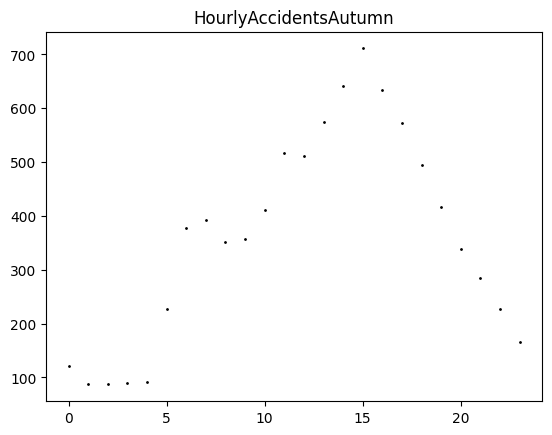

In [5]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsAutumn"])

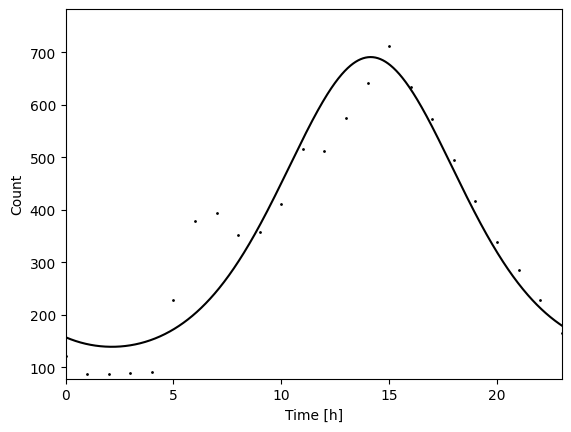

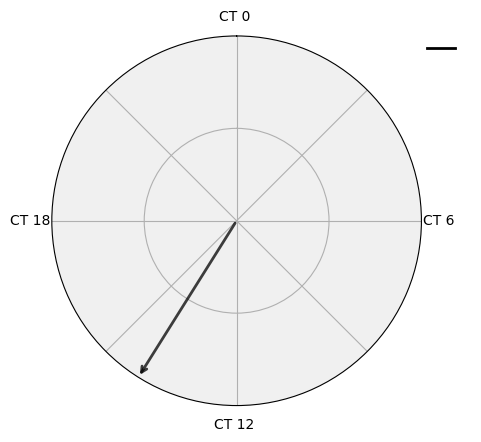

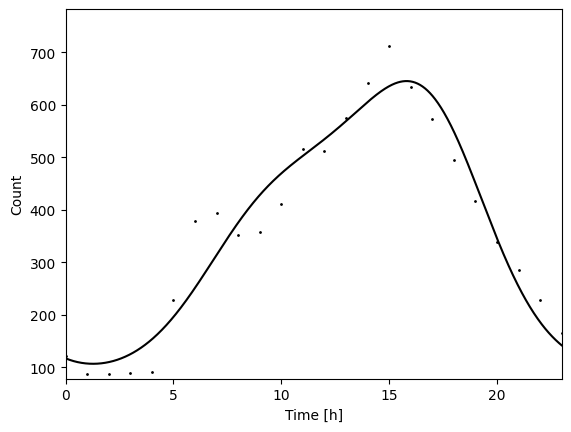

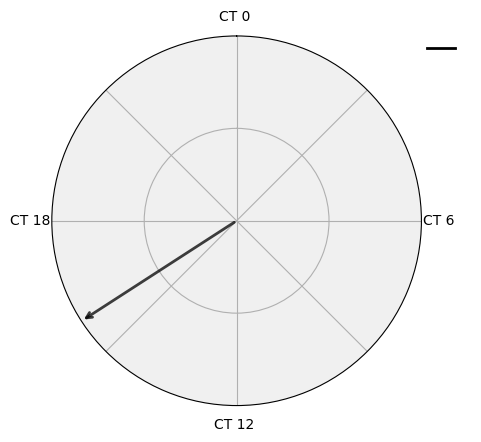

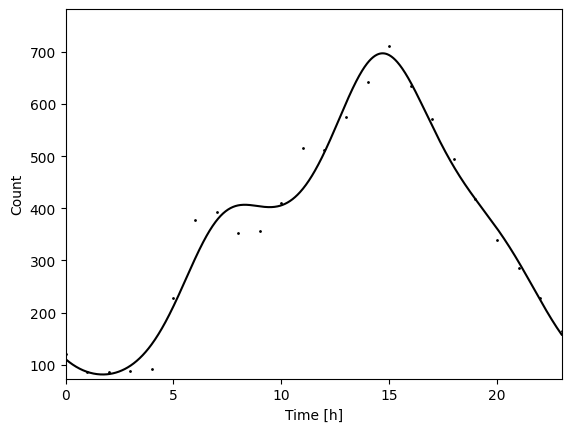

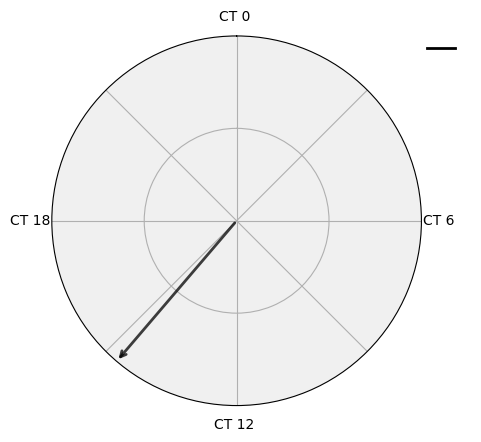

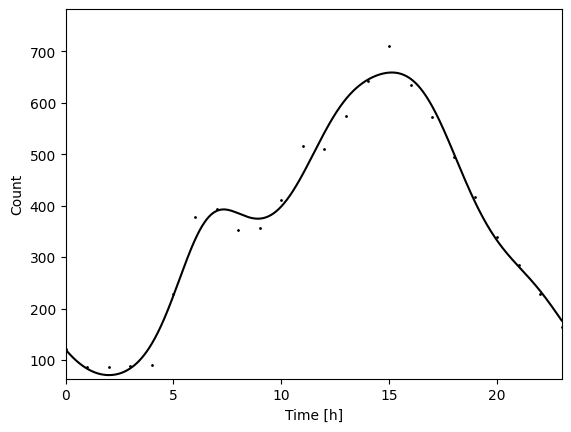

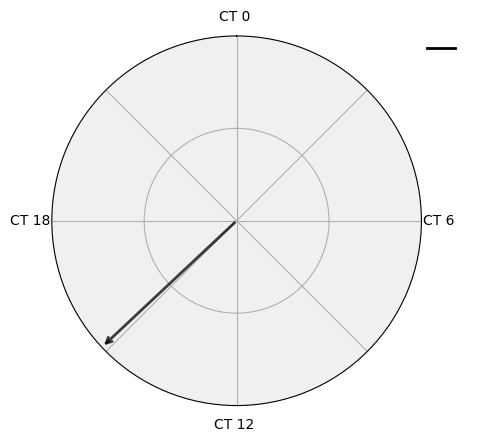

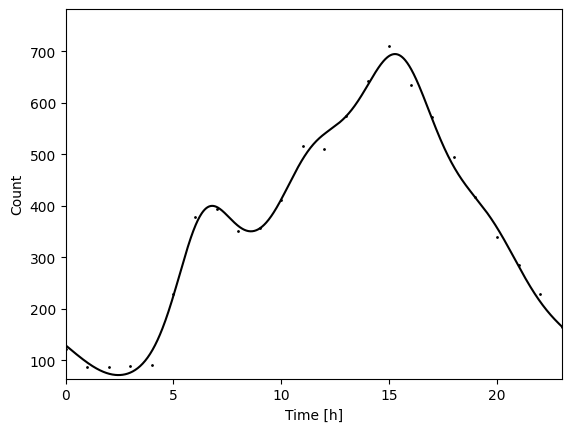

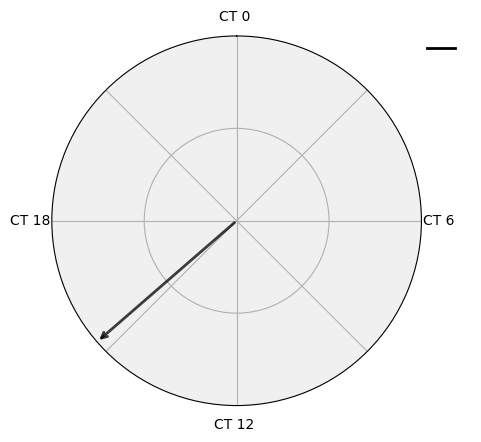

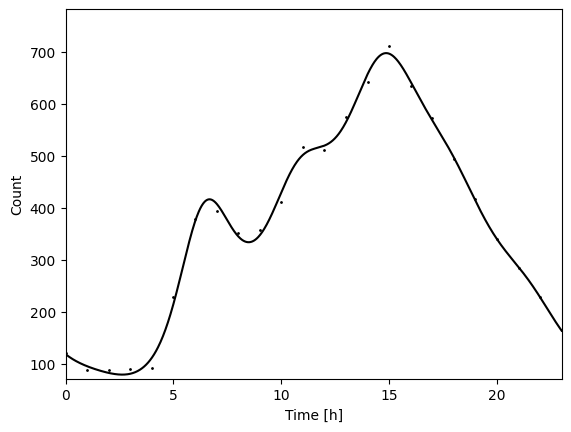

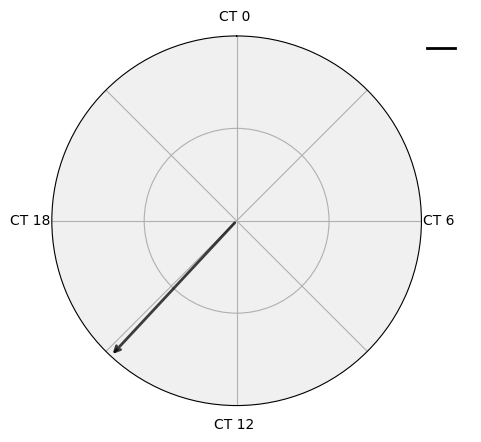

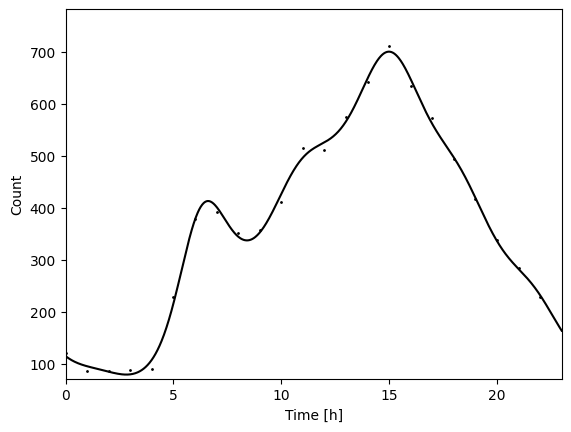

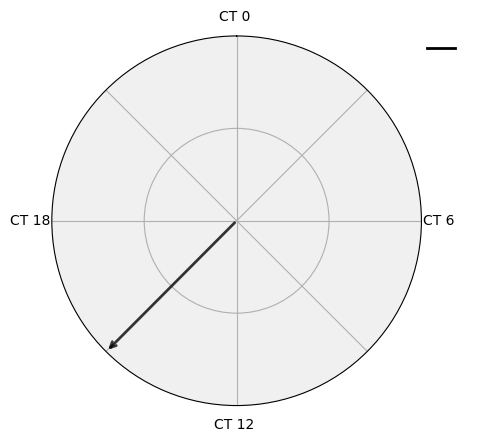

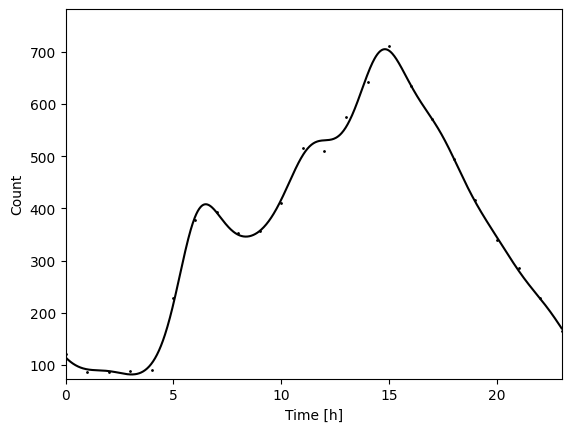

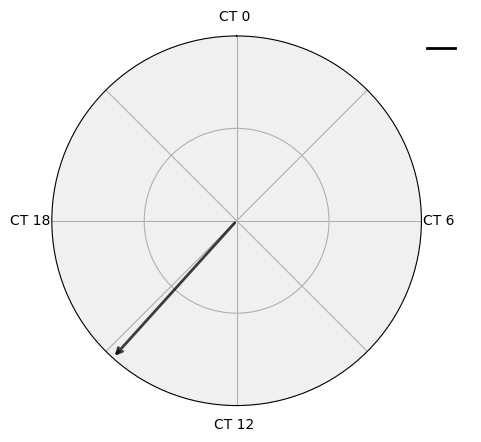

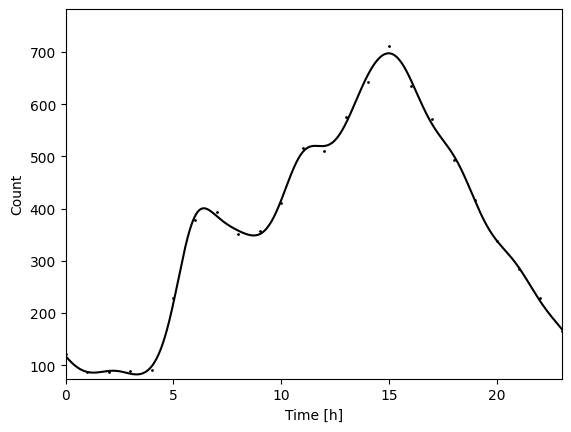

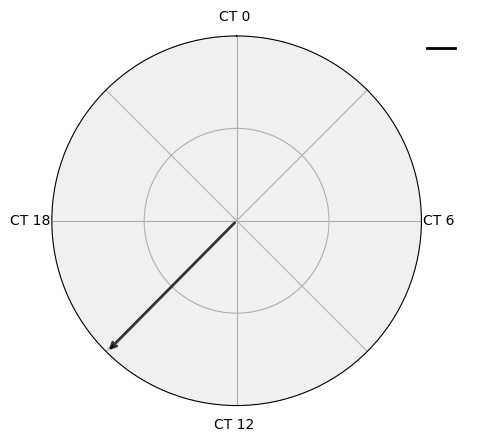

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


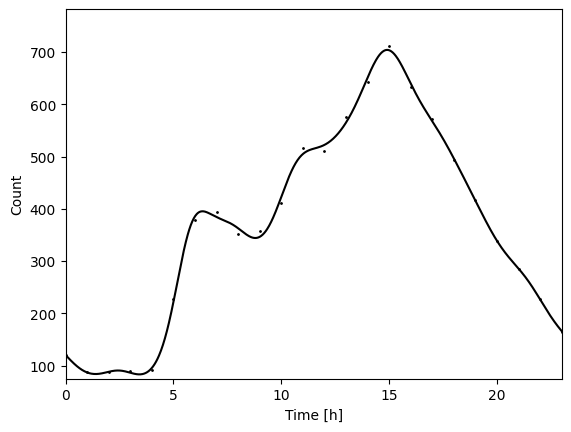

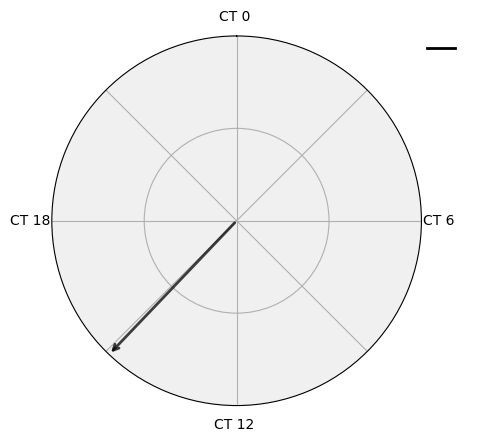

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsAutumn', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsAutumn', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsAutumn',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [7]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsAutumn,24.0,1.0,1.779015e-12,1.779015e-12,99102.892703,-134.438166,0.167530,275.844923,2.580762,414.958166,[14.142214221422144],[690.803089221457],[2.1410141014101414],[139.1132458673682],276.876332,281.588548
1,HourlyAccidentsAutumn,24.0,2.0,3.802555e-14,4.225061e-14,55870.889876,-127.023945,0.213441,269.180584,2.144666,375.922753,[15.807980798079809],[645.1033364587331],[1.2721272127212722],[106.7421690799039],266.047891,273.116214
2,HourlyAccidentsAutumn,24.0,3.0,2.022788e-17,2.528485e-17,23534.190339,-116.070779,0.281265,307.988908,2.434978,389.362356,"[8.304830483048306, 14.699069906990701]","[406.87456309786006, 697.351264381848]",[1.7233723372337235],[81.37344825614913],248.141558,257.565989
3,HourlyAccidentsAutumn,24.0,4.0,1.095824e-18,1.565464e-18,14288.866540,-110.049545,0.318550,294.165411,2.324383,364.705227,"[7.325532553255326, 15.121512151215123]","[392.6642287182765, 658.870604300911]",[2.006600660066007],[70.53986507125082],240.099089,251.879627
4,HourlyAccidentsAutumn,24.0,5.0,3.139748e-21,5.232914e-21,5534.414460,-100.982583,0.374694,311.811357,2.285423,383.017510,"[6.797479747974798, 15.270327032703271]","[399.9132777670306, 694.8288342306212]","[2.4434443444344436, 8.58805880588059]","[71.20622006623996, 350.4298518582909]",225.965167,240.101813
5,HourlyAccidentsAutumn,24.0,6.0,7.525564e-24,1.881391e-23,2414.277096,-91.738758,0.431934,309.230329,2.392248,388.261030,"[6.667866786678668, 14.862286228622864]","[416.26817203241853, 697.4913597771489]","[2.6258625862586262, 8.482448244824482]","[79.03071904875405, 333.68803895788955]",211.477516,227.970269
6,HourlyAccidentsAutumn,24.0,7.0,2.136296e-23,4.272591e-23,2198.441634,-90.183256,0.441566,310.394294,2.358315,389.973942,"[6.605460546054606, 14.991899189918993]","[413.21953736736793, 700.3682355400686]","[2.8130813081308133, 8.405640564056407]","[79.5796481262724, 337.50537100124905]",212.366512,231.215373
7,HourlyAccidentsAutumn,24.0,8.0,4.395088e-24,1.465029e-23,1805.318495,-85.859773,0.468338,311.810609,2.407329,393.460690,"[6.4950495049504955, 14.804680468046806]","[407.99891058678554, 705.2712989536299]","[3.0531053105310533, 8.357635763576358]","[81.65015921290615, 345.9575702620787]",207.719547,228.924516
8,HourlyAccidentsAutumn,24.0,9.0,2.707734e-25,1.353867e-24,1398.962618,-80.247154,0.503092,307.449132,2.362086,390.096076,"[6.408640864086409, 11.573957395739574, 14.977...","[400.7547117694455, 520.2655329121201, 697.545...","[1.2913291329132914, 3.2883288328832885, 8.717...","[86.04404940166364, 82.64698084759448, 348.678...",200.494309,224.055386
9,HourlyAccidentsAutumn,24.0,10.0,1.055473e-25,1.055473e-24,1129.649214,-76.713070,0.524976,310.484044,2.379680,393.560809,"[6.346234623462347, 14.910291029102911]","[395.21852772036567, 704.0446695052774]","[1.3873387338733874, 3.417941794179418, 8.7944...","[83.77259228261454, 83.0767647995085, 344.0775...",197.426140,223.343325


### Katero je najboljše število komponent

In [8]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model
#print(df_best_model)

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsAutumn,24,3,2.022788e-17,23534.190339,-116.070779,0.281265,248.141558,257.565989,307.988908,2.434978,389.362356,"[8.304830483048306, 14.699069906990701]","[406.87456309786006, 697.351264381848]",[1.7233723372337235],[81.37344825614913]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


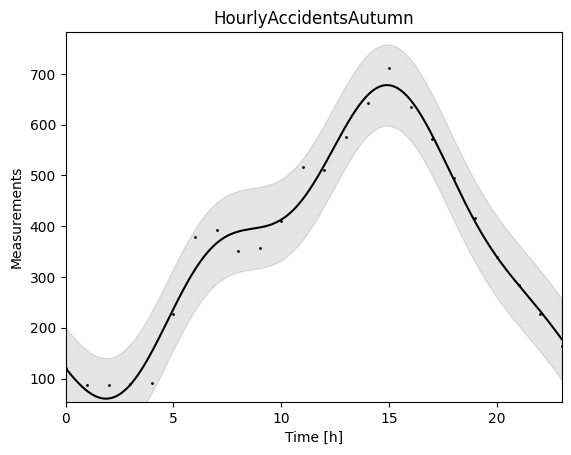

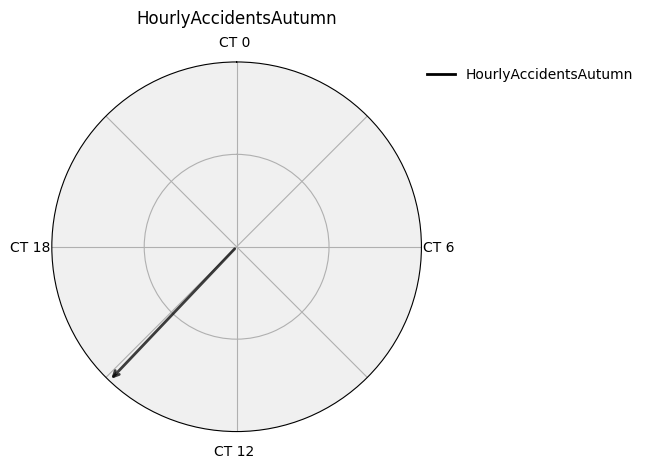

In [9]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsAutumn",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

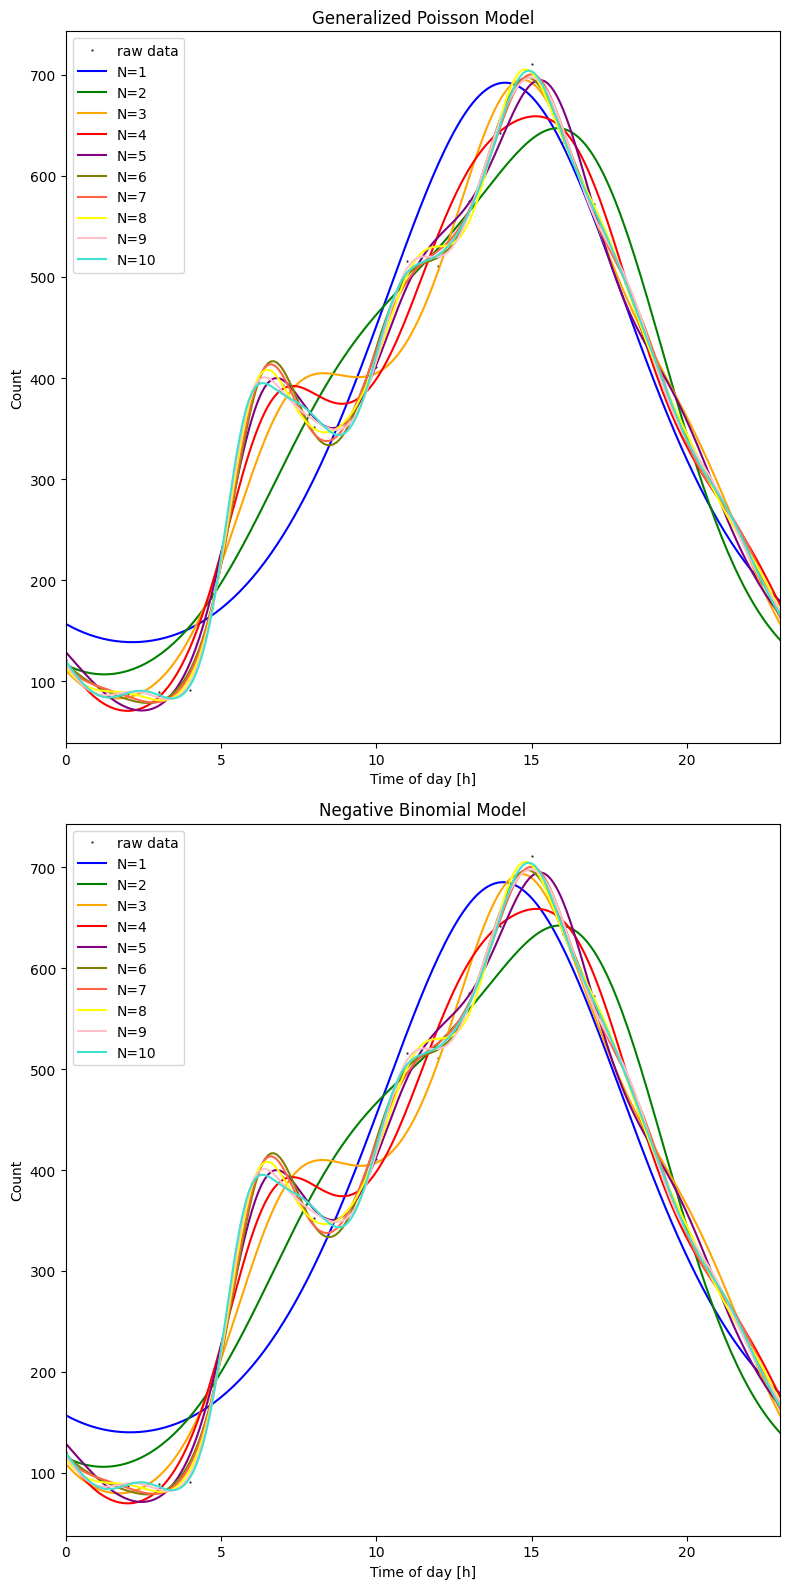

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,276.73,415.44,[14.11],[692.17],1.781364e-12,99658.141291,276.878972,281.591188,-134.439486,"[-4.826583516184883, -5.256560838236624, -5.10...",361.955783,"[156.89046800408033, 143.74849486264063, 138.7...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[156.89046800408033, 155.17864419836084, 153.5..."
1,gen_poisson,2,270.17,377.02,[15.82],[647.19],3.937476e-14,55117.303238,266.119649,273.187971,-127.059824,"[-4.372433140279384, -4.333269644280136, -4.41...",360.466186,"[116.60460158674942, 107.18525094721434, 110.3...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[116.60460158674942, 115.0447890985979, 113.62..."
2,gen_poisson,3,305.94,389.10,[14.71],[695.04],1.391920e-16,22893.778092,252.176797,261.601228,-118.088399,"[-3.8765193520216883, -3.4564146096189603, -3....",362.035368,"[111.06039144515206, 87.62255238450695, 84.108...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[111.06039144515206, 107.74039690841195, 104.6..."
3,gen_poisson,4,294.13,364.86,[15.12],[658.99],1.673580e-17,14163.611568,245.891777,257.672315,-112.945888,"[-3.317013125536022, -3.251497269972475, -4.91...",361.791667,"[119.531227433726, 82.7639970873317, 70.730580...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[119.531227433726, 114.76659117374379, 110.226..."
4,gen_poisson,5,311.83,382.94,[15.32],[694.77],3.234872e-21,5526.646427,226.029009,240.165655,-101.014505,"[-3.5357967313226197, -3.5351978068012357, -4....",361.791667,"[129.07035921018644, 95.49596815868533, 73.755...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[129.07035921018644, 125.53574182696202, 122.0..."
5,gen_poisson,6,309.39,387.98,[14.81],[697.37],6.336919e-23,2434.053020,216.068377,232.561131,-94.034189,"[-3.240418890606321, -3.506925783370292, -3.21...",361.791667,"[118.36375753425179, 95.23642965441671, 82.071...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[118.36375753425179, 115.24855001955363, 112.3..."
6,gen_poisson,7,310.69,389.81,[15.02],[700.49],3.520781e-22,2220.964990,218.489483,237.338344,-93.244741,"[-3.4042427321553106, -3.547534390024637, -3.0...",361.791667,"[114.83305777116907, 95.60509993159387, 84.998...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[114.83305777116907, 111.82354211761867, 109.1..."
7,gen_poisson,8,312.13,393.25,[14.81],[705.38],7.667857e-22,1814.012777,219.124255,240.329224,-91.562128,"[-3.4612718565471, -3.192026119460195, -3.0558...",361.791667,"[114.03047592270045, 91.57067351037016, 88.310...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[114.03047592270045, 110.10373988637704, 106.5..."
8,gen_poisson,9,307.53,389.78,[15.02],[697.31],1.925960e-21,1402.129561,220.281677,243.842754,-90.140839,"[-3.259385506387474, -3.045206736855249, -3.08...",361.791667,"[117.73708668382666, 87.59132886613911, 89.480...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[117.73708668382666, 113.01515149027401, 108.5..."
9,gen_poisson,10,310.55,393.57,[14.91],[704.12],9.109857e-21,1129.726272,223.067358,248.984542,-89.533679,"[-3.2088047051965702, -3.0418562354612533, -3....",361.791667,"[120.24553407823028, 86.89530148167027, 88.307...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[120.24553407823028, 115.82156712499271, 111.5..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


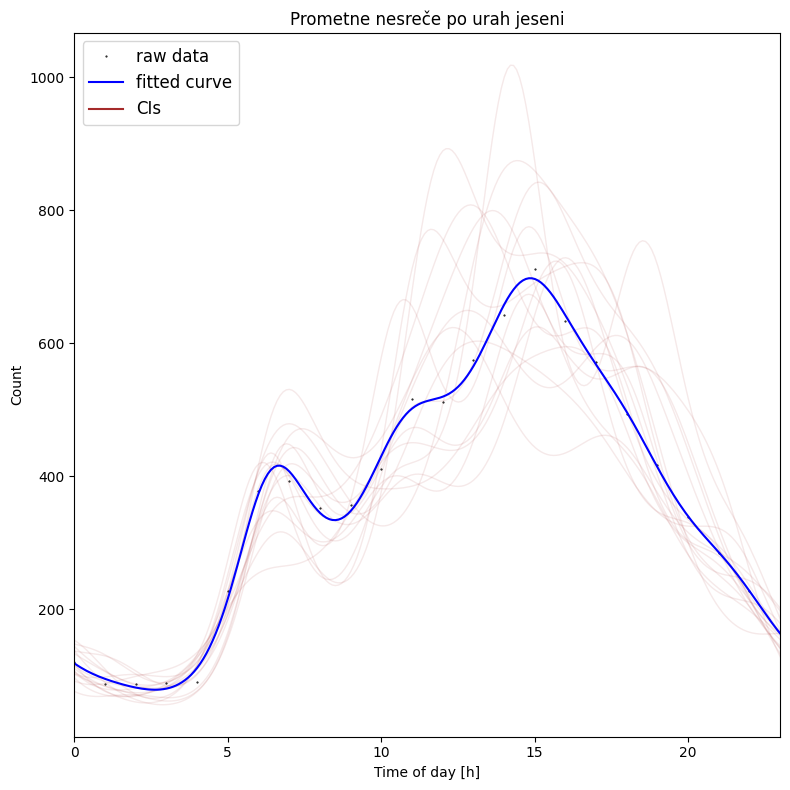

Intervali zaupanja:


,0,1
0,5.587751,5.787156
1,-0.589652,-0.299363
2,-0.899428,-0.684764
3,-0.307727,-0.029355
4,-0.303610,-0.107227
5,-0.271175,-0.115044
6,-0.065321,0.183368
7,-0.096170,0.071678
8,-0.002098,0.187221
9,0.008336,0.161526


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah jeseni', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,309.39
mesor,387.98
peaks,[14.81]
heights,[697.37]
amplitude_CIs,"[162.78, 531.38]"
mesor_CIs,"[251.87, 591.88]"
peaks_CIs,"[13.87, 15.91]"
heights_CIs,"[640.58, 749.76]"
